<a href="https://colab.research.google.com/github/KoNGoL/tfm_breast_cancer_detection/blob/main/notebooks/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install tfa-nightly
#importacion de librerias
import numpy as np
import pandas as pd
import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.models import *
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD, Adadelta, Adagrad
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications import VGG16
from keras.applications import densenet
from keras import regularizers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import time
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
from PIL import Image
import os
import PIL
import glob
from io import BytesIO
import timeit
import os
import warnings
import statistics
# warnings.filterwarnings('ignore')
# from tensorflow.python.keras.applications.efficientnet import EfficientNetB0
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))
print(tf.test.is_gpu_available())
# tf.config.experimental.set_memory_growth = True
# %cd /home/fundamentia/Dropbox/Master/Asignaturas/Deep Learning/PRA1/archive/practica_DL_UOC_2022
def freeze_layers(model):
    for i in model.layers:
        i.trainable = False
        if isinstance(i, Model):
            freeze_layers(i)
    return model

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/TFM/DenseNet_models/
%cp -r /content/drive/MyDrive/TFM/Fold0 /content/


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 37.6 MB/s 
2.9.2


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
Mounted at /content/drive
/content/drive/MyDrive/TFM/DenseNet_models
^C


In [ ]:
def create_DenseNet(model_name, fold_path, model_path, optimizer=Adam(learning_rate=0.0001)):
  inputs = tf.keras.Input(shape=(224, 224, 3))
  head_model = densenet.DenseNet121(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

  head_model.trainable = True

  head_model = head_model(inputs, training = True)
  head_model = tf.keras.layers.Flatten()(head_model)
  head_model = tf.keras.layers.Dense(256, activation='relu')(head_model)

  # head_model = tf.keras.layers.Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01), activation='relu')(head_model)
  # # head_model = Activation('relu')(head_model)
  # head_model = tf.keras.layers.Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01), activation='relu')(head_model)
  # # head_model = Activation('relu')(head_model)
  output = Dense(3, activation='softmax')(head_model)
  model4 = Model(inputs=inputs, outputs = output)

  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )


  # Note that the validation data should not be augmented!
  train_generator = train_datagen.flow_from_directory(fold_path + '/Train',
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))     

  validation_datagen  = ImageDataGenerator(rescale=1./255)
  validation_generator =  validation_datagen.flow_from_directory(fold_path + '/Valid',
                                                          batch_size=32,
                                                          class_mode  = 'categorical',
                                                          target_size = (224, 224))

  # compilamos el modelo y lo entrenamos
  model4.compile(loss="categorical_crossentropy", 
                optimizer=optimizer,
                metrics=[tfa.metrics.F1Score(num_classes=3, average='micro'), 'accuracy'])
  
  return model4, train_generator, validation_generator

In [ ]:
def train_DenseNet_model(model4, train_generator, validation_generator, model_path, model_name, epochs=100):
  batch_size = 32
  steps_per_epoch = train_generator.n // batch_size
  validation_steps = validation_generator.n // batch_size

  # generamos un monitor para el earlystop cuando el modelo este entrenado
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, min_delta=0.001)
  # generamos el callback de guardado del modelo
  filepath = model_path + model_name + "_best.hdf5"
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_score', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

  model4_history = model4.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      callbacks = [early_stop, checkpoint], 
      validation_data = validation_generator,
      validation_steps = validation_steps
  )
  return model4, model4_history

In [ ]:
model_path4 = '/content/drive/MyDrive/TFM/DenseNet_models/model_DenseNet_hyper/'
optimizers = [{'type':Adam, 'name': 'Adam'}, {'type':SGD, 'name': 'SGD'}, {'type':Adagrad, 'name': 'Adagrad'}]

model_path4 = '/content/drive/MyDrive/TFM/DenseNet_models/model_DenseNet_hyper/'
i = 0
for opt in optimizers:
  for lr in lrs: 
    print(opt['name'])
    model_name = "model_DenseNet_{}_{}".format(opt['name'], lr)
    model4, train_generator, validation_generator = create_DenseNet(model_name, '/content/Fold0', model_path4, opt['type'](learning_rate=lr))
    model4.summary()

    model4, model4_history = train_DenseNet_model(model4, train_generator, validation_generator, model_path4, model_name, 40)
    np.save(model_path4 + '{}-History.npy'.format(model_name), model4_history.history)
  

Adagrad
Found 3324 images belonging to 3 classes.
Found 1106 images belonging to 3 classes.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               12845312  
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 19,883,587
Trainable params: 19,799,939
Non-trainable params: 83,648
________________

model_DenseNet_Adam_0.01


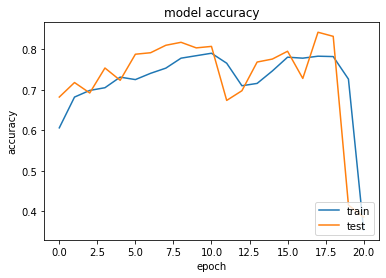

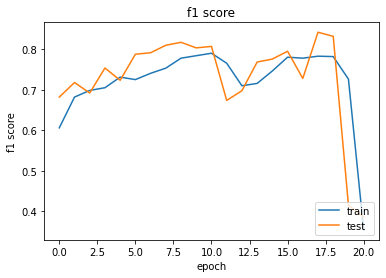

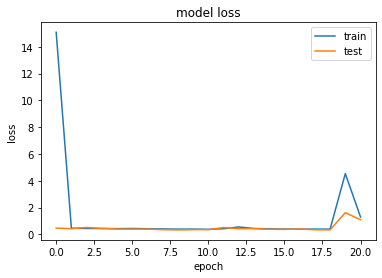

Found 1106 images belonging to 3 classes.
35/35 [==============================] - 8s 120ms/step - loss: 0.3519 - f1_score: 0.8282 - accuracy: 0.8282
Test f1: 0.8282097578048706
Test Accuracy: 0.8282097578048706
model_DenseNet_Adam_0.001


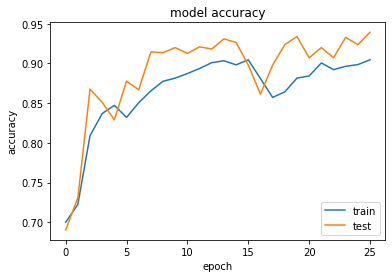

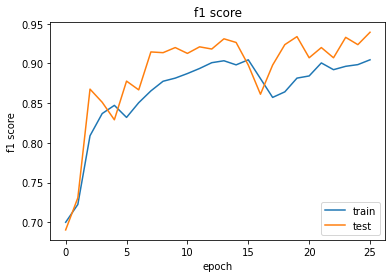

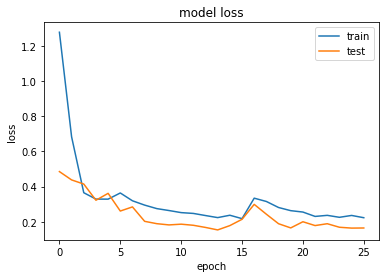

Found 1106 images belonging to 3 classes.
35/35 [==============================] - 9s 120ms/step - loss: 0.1691 - f1_score: 0.9313 - accuracy: 0.9313
Test f1: 0.9312838912010193
Test Accuracy: 0.9312838912010193
model_DenseNet_Adam_0.0001


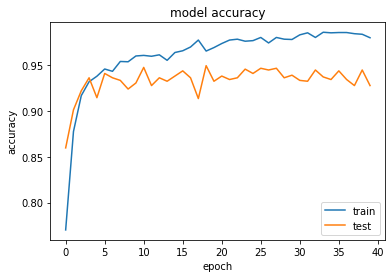

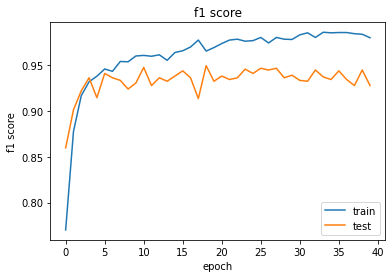

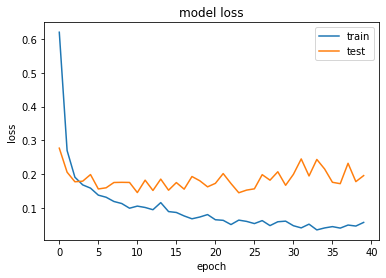

Found 1106 images belonging to 3 classes.
35/35 [==============================] - 8s 119ms/step - loss: 0.1049 - f1_score: 0.9665 - accuracy: 0.9665
Test f1: 0.9665461182594299
Test Accuracy: 0.9665461182594299
model_DenseNet_SGD_0.01


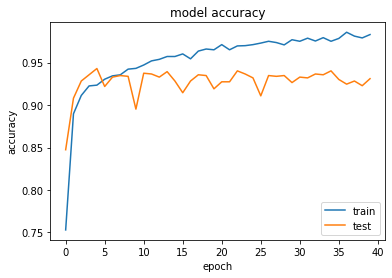

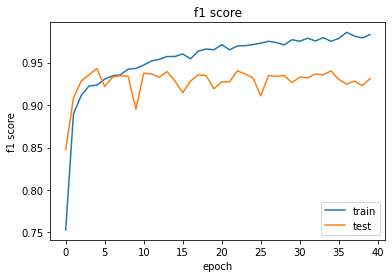

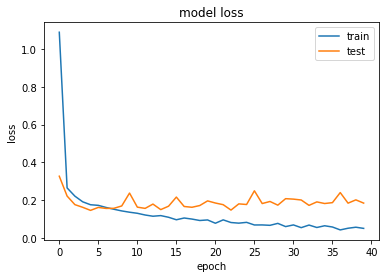

Found 1106 images belonging to 3 classes.
35/35 [==============================] - 8s 121ms/step - loss: 0.1603 - f1_score: 0.9268 - accuracy: 0.9268
Test f1: 0.926763117313385
Test Accuracy: 0.926763117313385
model_DenseNet_SGD_0.001


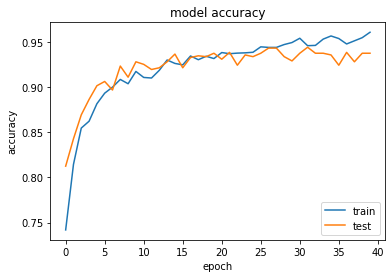

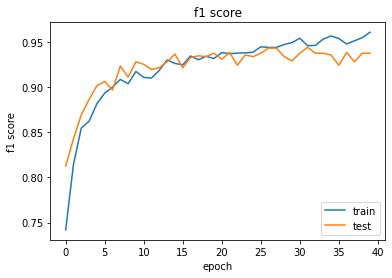

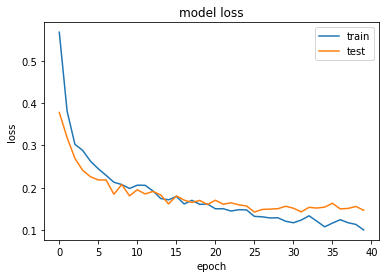

Found 1106 images belonging to 3 classes.
35/35 [==============================] - 8s 121ms/step - loss: 0.1200 - f1_score: 0.9512 - accuracy: 0.9512
Test f1: 0.9511753916740417
Test Accuracy: 0.9511753916740417
model_DenseNet_SGD_0.0001


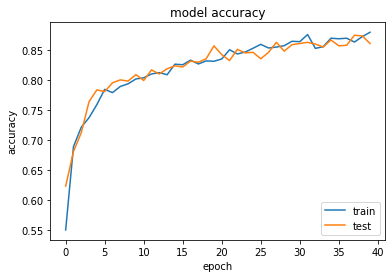

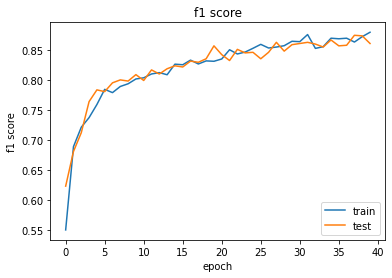

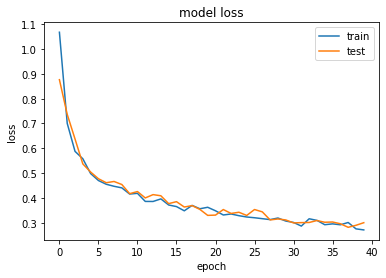

Found 1106 images belonging to 3 classes.
35/35 [==============================] - 8s 121ms/step - loss: 0.2785 - f1_score: 0.8734 - accuracy: 0.8734
Test f1: 0.8734177947044373
Test Accuracy: 0.8734177350997925
model_DenseNet_Adagrad_0.01


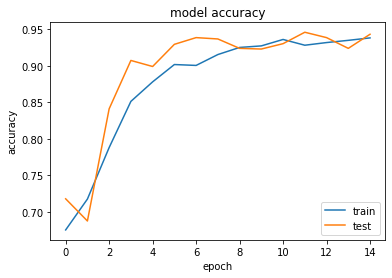

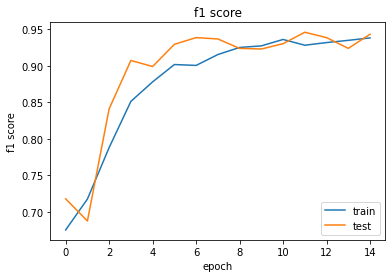

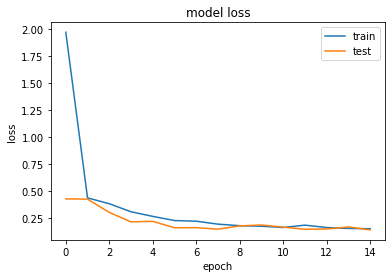

Found 1106 images belonging to 3 classes.
35/35 [==============================] - 8s 123ms/step - loss: 0.1466 - f1_score: 0.9421 - accuracy: 0.9421
Test f1: 0.9421338438987732
Test Accuracy: 0.9421338438987732
model_DenseNet_Adagrad_0.001


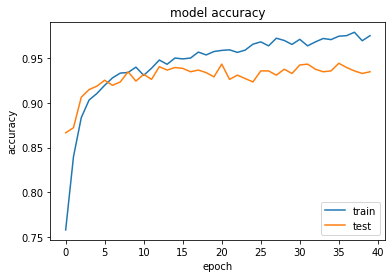

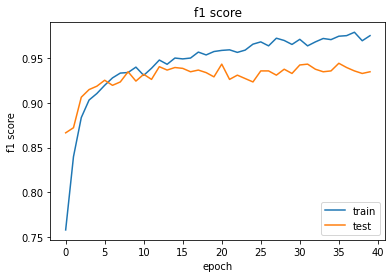

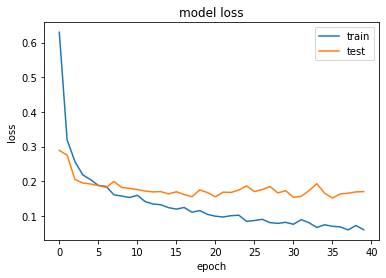

Found 1106 images belonging to 3 classes.
35/35 [==============================] - 8s 123ms/step - loss: 0.1105 - f1_score: 0.9629 - accuracy: 0.9629
Test f1: 0.9629294872283936
Test Accuracy: 0.9629294872283936
model_DenseNet_Adagrad_0.0001


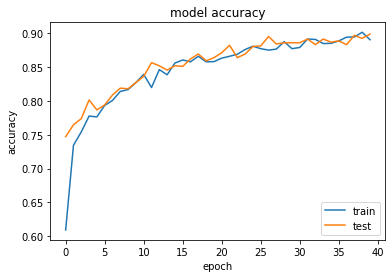

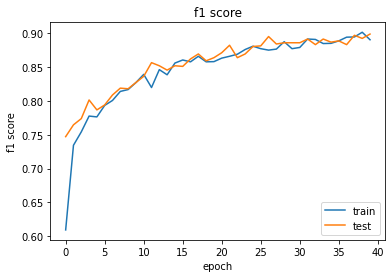

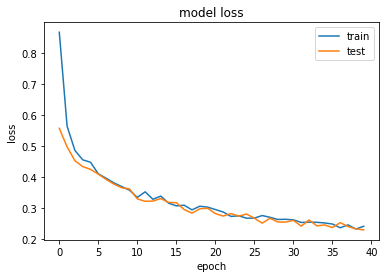

Found 1106 images belonging to 3 classes.
35/35 [==============================] - 8s 124ms/step - loss: 0.2277 - f1_score: 0.8951 - accuracy: 0.8951
Test f1: 0.8951175212860107
Test Accuracy: 0.8951175212860107


In [ ]:
model_path4 = '/content/drive/MyDrive/TFM/DenseNet_models/model_DenseNet_hyper/'
optimizers = [{'type':Adam, 'name': 'Adam'}, {'type':SGD, 'name': 'SGD'}, {'type':Adagrad, 'name': 'Adagrad'}]
lrs = [0.01, 0.001, 0.0001]

inputs = tf.keras.Input(shape=(224, 224, 3))
head_model = densenet.DenseNet121(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

head_model.trainable = True

head_model = head_model(inputs, training = True)
head_model = tf.keras.layers.Flatten()(head_model)
head_model = tf.keras.layers.Dense(256, activation='relu')(head_model)
# output = Dense(2, activation='softmax')(head_model)
output = Dense(3, activation='softmax')(head_model)
model_eval = Model(inputs=inputs, outputs = output)

for opt in optimizers:
  for lr in lrs: 
    name = "model_DenseNet_{}_{}".format(opt['name'], lr)
    print(name)
    model4_history = np.load(model_path4 + '{}-History.npy'.format(name),allow_pickle='TRUE').item()
    # model4 = keras.models.load_model(model_path4 + name +"_best.hdf5")

    model_eval.load_weights(model_path4 + "{}_best.hdf5".format(name))
    model_eval.compile(loss="categorical_crossentropy", 
                  optimizer=opt['type'](learning_rate=lr),
                  metrics=[tfa.metrics.F1Score(num_classes=3, average='micro'), 'accuracy'])

    # Visualizamos la evolución de la accuracy
    plt.plot(model4_history['accuracy'])
    plt.plot(model4_history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

    plt.plot(model4_history['f1_score'])
    plt.plot(model4_history['val_f1_score'])
    plt.title('f1 score')
    plt.ylabel('f1 score')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

    plt.plot(model4_history['loss'])
    plt.plot(model4_history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    test_datagen  = ImageDataGenerator(rescale=1./255)
    test_generator =  test_datagen.flow_from_directory('/content/Fold0/Valid',
                                                              batch_size=32,
                                                              class_mode  = 'categorical',
                                                              target_size = (224, 224))

    test_lost, test_f1, test_acc = model_eval.evaluate(test_generator)
    print ("Test f1:", test_f1)
    print ("Test Accuracy:", test_acc)

    # test_generator.reset()
    # predict = model_eval.predict(test_generator)
    # y_pred = np.rint(predict)
    # y_true = test_generator.classes
    # pred2 = []
    # for p in y_pred:
    #   pred2.append(np.argmax(p))

    # matrix = confusion_matrix(y_true, pred2)
    # fig, ax = plt.subplots(figsize=(5, 5))
    # disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Calc', 'Mass', 'Otros'])
    # disp.plot(cmap=plt.cm.Blues, ax=ax)
    # plt.title("Matriz de confusión")
    # plt.show()

In [ ]:
# model3, train_generator, validation_generator = create_DenseNet("", '/content/Fold0', "", Adagrad(learning_rate=0.01))
# model3.load_weights('/content/drive/MyDrive/TFM/DenseNet_models/model_DenseNet_hyper/model_DenseNet_Adam_0.0001_best.hdf5')
 
# model3.compile(loss="categorical_crossentropy", 
#               optimizer=Adagrad(learning_rate=0.01),
#               metrics=[tfa.metrics.F1Score(num_classes=3, average='micro'), 'accuracy'])


test_datagen  = ImageDataGenerator(rescale=1./255)
test_generator =  test_datagen.flow_from_directory('/content/Fold0/Test',
                                                          batch_size=32,
                                                          class_mode  = 'categorical',
                                                          target_size = (224, 224), shuffle=False)

# test_lost, test_f1, test_acc = model4.evaluate(test_generator)
# print ("Test f1:", test_f1)
# print ("Test Accuracy:", test_acc)

Found 553 images belonging to 3 classes.


18/18 [==============================] - 6s 166ms/step


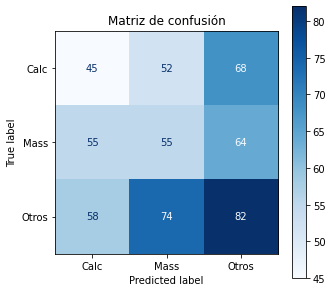

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [ ]:
# validation_datagen2  = ImageDataGenerator(rescale=1./255)
# validation_generator2 =  validation_datagen2.flow_from_directory('/content/Fold0/Valid',
#                                                         batch_size=32,
#                                                         class_mode  = 'categorical',
#                                                         target_size = (224, 224))
predict = model3.predict(test_generator)
y_pred = np.rint(predict)
y_true = test_generator.classes
pred2 = []
for p in y_pred:
  pred2.append(np.argmax(p))

matrix = confusion_matrix(y_true, pred2)
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Calc', 'Mass', 'Otros'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Matriz de confusión")
plt.show()
print(y_true)

model_DenseNet_Adam_0.01
model_DenseNet_Adam_0.001
model_DenseNet_Adam_0.0001


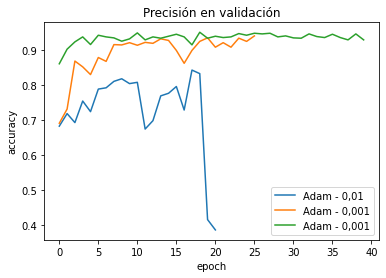

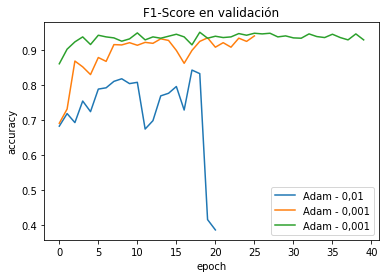

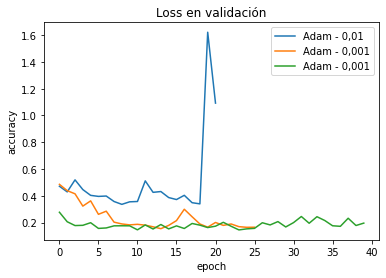

model_DenseNet_SGD_0.01
model_DenseNet_SGD_0.001
model_DenseNet_SGD_0.0001


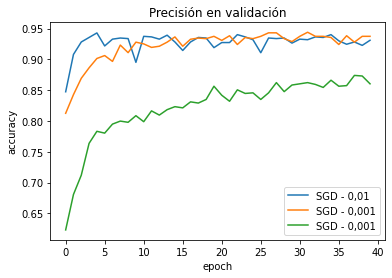

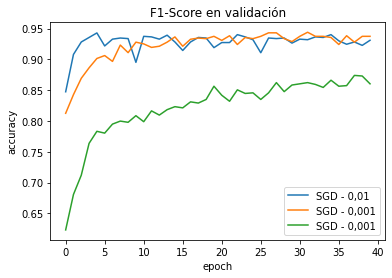

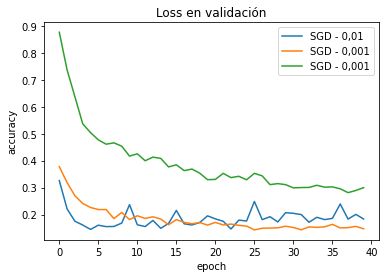

model_DenseNet_Adagrad_0.01
model_DenseNet_Adagrad_0.001
model_DenseNet_Adagrad_0.0001


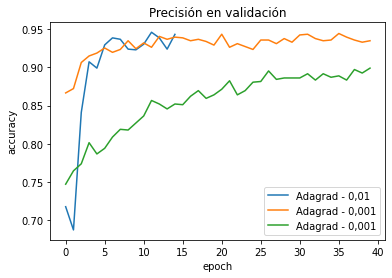

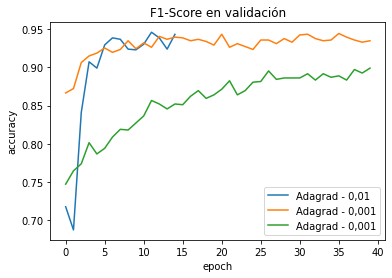

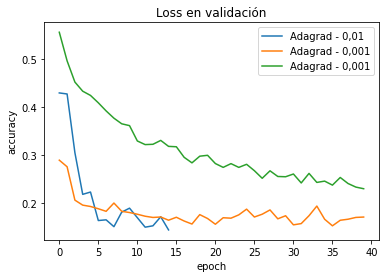

In [3]:
model_path4 = '/content/drive/MyDrive/TFM/DenseNet_models/model_DenseNet_hyper/'
optimizers = [{'type':Adam, 'name': 'Adam'}, {'type':SGD, 'name': 'SGD'}, {'type':Adagrad, 'name': 'Adagrad'}]
lrs = [0.01, 0.001, 0.0001]

for opt in optimizers:
  accuracy = []
  f1 = []
  loss = []
  for lr in lrs: 
    name = "model_DenseNet_{}_{}".format(opt['name'], lr)
    print(name)
    model4_history = np.load(model_path4 + '{}-History.npy'.format(name),allow_pickle='TRUE').item()
    accuracy.append(model4_history['val_accuracy'])
    f1.append(model4_history['val_f1_score'])
    loss.append(model4_history['val_loss'])

  # Visualizamos la evolución de la accuracy
  # plt.plot(model4_history['accuracy'])
  plt.plot(accuracy[0])
  plt.plot(accuracy[1])
  plt.plot(accuracy[2])
  plt.title('Precisión en validación')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend([opt['name'] + ' - 0,01', opt['name'] + ' - 0,001', opt['name'] + ' - 0,001'], loc='lower right')
  plt.show()
  
  plt.plot(f1[0])
  plt.plot(f1[1])
  plt.plot(f1[2])
  plt.title('F1-Score en validación')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend([opt['name'] + ' - 0,01', opt['name'] + ' - 0,001', opt['name'] + ' - 0,001'], loc='lower right')
  plt.show()


  plt.plot(loss[0])
  plt.plot(loss[1])
  plt.plot(loss[2])
  plt.title('Loss en validación')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend([opt['name'] + ' - 0,01', opt['name'] + ' - 0,001', opt['name'] + ' - 0,001'], loc='upper right')
  plt.show()